In [17]:
import argparse
import sys
import os
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch

from models import Generator
from datasets import ImageDataset

parser = argparse.ArgumentParser()
parser.add_argument('--batchSize', type=int, default=1, help='size of the batches')
parser.add_argument('--dataroot', type=str, default='datasets/summer2winter_yosemite/', help='root directory of the dataset')
parser.add_argument('--input_nc', type=int, default=3, help='number of channels of input data')
parser.add_argument('--output_nc', type=int, default=3, help='number of channels of output data')
parser.add_argument('--size', type=int, default=256, help='size of the data (squared assumed)')
parser.add_argument('--cuda', action='store_true', help='use GPU computation')
parser.add_argument('--n_cpu', type=int, default=8, help='number of cpu threads to use during batch generation')
parser.add_argument('--generator_A2B', type=str, default='output/netG_A2B.pth', help='A2B generator checkpoint file')
parser.add_argument('--generator_B2A', type=str, default='output/netG_B2A.pth', help='B2A generator checkpoint file')
opt = parser.parse_args('')

In [2]:
if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

###### Definition of variables ######
# Networks
netG_A2B = Generator(opt.input_nc, opt.output_nc)
netG_B2A = Generator(opt.output_nc, opt.input_nc)

if opt.cuda:
    netG_A2B.cuda()
    netG_B2A.cuda()

# Load state dicts
netG_A2B.load_state_dict(torch.load(opt.generator_A2B))
netG_B2A.load_state_dict(torch.load(opt.generator_B2A))

# Set model's test mode
netG_A2B.eval()
netG_B2A.eval()

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if opt.cuda else torch.Tensor
input_A = Tensor(opt.batchSize, opt.input_nc, opt.size, opt.size)
input_B = Tensor(opt.batchSize, opt.output_nc, opt.size, opt.size)

# Dataset loader
transforms_ = [ transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(ImageDataset(opt.dataroot, transforms_=transforms_, mode='test'), 
                        batch_size=opt.batchSize, shuffle=False, num_workers=opt.n_cpu)
###################################

###### Testing######

# Create output dirs if they don't exist
if not os.path.exists('output/A'):
    os.makedirs('output/A')
if not os.path.exists('output/B'):
    os.makedirs('output/B')

In [25]:
A, B = next(iter(dataloader))['A'], next(iter(dataloader))['B']

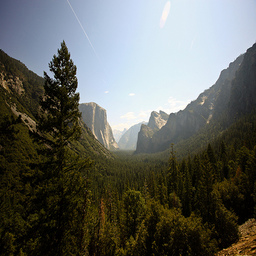

In [26]:
real_A = Variable(A)
# Remove the batch dimension (1, 3, 256, 256) -> (3, 256, 256)
real_A = real_A.squeeze(0)

# Convert the tensor to a numpy array
np_img = real_A.numpy()

# Transpose the numpy array from (3, 256, 256) to (256, 256, 3) for displaying
np_img = np.transpose(np_img, (1, 2, 0))
# Normalize the image for display (optional, here assuming the tensor values are in standard normal distribution)
np_img = (np_img - np_img.min()) / (np_img.max() - np_img.min())
np_img = (np_img * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8

# Convert the numpy array to a PIL image
img = Image.fromarray(np_img)

# Display the image
img

In [27]:
fake_B = 0.5*(netG_A2B(real_A).data + 1.0)

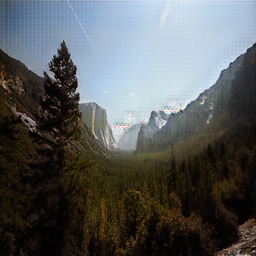

In [28]:
# Remove the batch dimension (1, 3, 256, 256) -> (3, 256, 256)
fake_B = fake_B.squeeze(0)

# Convert the tensor to a numpy array
np_img = fake_B.numpy()

# Transpose the numpy array from (3, 256, 256) to (256, 256, 3) for displaying
np_img = np.transpose(np_img, (1, 2, 0))
# Normalize the image for display (optional, here assuming the tensor values are in standard normal distribution)
np_img = (np_img - np_img.min()) / (np_img.max() - np_img.min())
np_img = (np_img * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8

# Convert the numpy array to a PIL image
img = Image.fromarray(np_img)

# Display the image
img

In [ ]:
for i, batch in enumerate(dataloader):
    # Set model input
    real_A = Variable(input_A.copy_(batch['A']))
    real_B = Variable(input_B.copy_(batch['B']))

    # Generate output
    fake_B = 0.5*(netG_A2B(real_A).data + 1.0)
    fake_A = 0.5*(netG_B2A(real_B).data + 1.0)

    # Save image files
    save_image(fake_A, 'output/A/%04d.png' % (i+1))
    save_image(fake_B, 'output/B/%04d.png' % (i+1))

    sys.stdout.write('\rGenerated images %04d of %04d' % (i+1, len(dataloader)))

sys.stdout.write('\n')